In [3]:
# ----- Imports: basic data & ML tools -----
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning tools
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Make plots show inside the notebook
%matplotlib inline

print("Imports done ✅")


Imports done ✅


In [4]:
# ----- Load cleaned retail data from CSV -----

# Path to the cleaned CSV file
csv_path = "E:/retail-ml-pipeline-project/data_processed/retail_clean_advanced.csv"
# Load the data into a pandas DataFrame
df = pd.read_csv(csv_path)

print("shape of DataFrame:", df.shape)
df.head()
print("Data loaded ✅")

shape of DataFrame: (779423, 14)
Data loaded ✅


In [5]:
# ----- Basic data inspection -----

# Column names
print("Columns:", df.columns.tolist())

# Info about data types and nulls
print("\nInfo:")
print(df.info())

# Quick statistics for numeric columns
print("\nDescribe (numeric features):")
display(df.describe())

# Check few unique countries
print("\nSample countries:", df['Country'].unique()[:10])

# Number of unique customers
print("\nNumber of unique customers:", df['CustomerID'].nunique())


Columns: ['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'CustomerID', 'Country', 'TotalPrice', 'InvoiceYear', 'InvoiceMonth', 'InvoiceDay', 'InvoiceHour', 'InvoiceWeekday']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 779423 entries, 0 to 779422
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Invoice         779423 non-null  int64  
 1   StockCode       779423 non-null  object 
 2   Description     779423 non-null  object 
 3   Quantity        779423 non-null  int64  
 4   InvoiceDate     779423 non-null  object 
 5   Price           779423 non-null  float64
 6   CustomerID      779423 non-null  int64  
 7   Country         779423 non-null  object 
 8   TotalPrice      779423 non-null  float64
 9   InvoiceYear     779423 non-null  int64  
 10  InvoiceMonth    779423 non-null  int64  
 11  InvoiceDay      779423 non-null  int64  
 12  InvoiceHour     779423 non-null

,Invoice,Quantity,Price,CustomerID,TotalPrice,InvoiceYear,InvoiceMonth,InvoiceDay,InvoiceHour,InvoiceWeekday
count,779423.000000,779423.000000,779423.000000,779423.000000,779423.000000,779423.000000,779423.000000,779423.000000,779423.000000,779423.000000
mean,537426.758579,13.489016,3.218488,15320.366620,22.291172,2010.432049,7.417057,15.390961,12.791886,2.641666
std,26901.623258,145.855640,29.676178,1695.690591,227.426620,0.568385,3.422320,8.657944,2.294184,1.951161
min,489434.000000,1.000000,0.001000,12346.000000,0.001000,2009.000000,1.000000,1.000000,6.000000,0.000000
25%,514483.000000,2.000000,1.250000,13971.000000,4.950000,2010.000000,5.000000,8.000000,11.000000,1.000000
50%,536754.000000,6.000000,1.950000,15247.000000,12.480000,2010.000000,8.000000,15.000000,13.000000,2.000000
75%,561995.000000,12.000000,3.750000,16794.000000,19.800000,2011.000000,11.000000,23.000000,14.000000,4.000000
max,581587.000000,80995.000000,10953.500000,18287.000000,168469.600000,2011.000000,12.000000,31.000000,20.000000,6.000000



Sample countries: ['United Kingdom' 'France' 'USA' 'Belgium' 'Australia' 'EIRE' 'Germany'
 'Portugal' 'Denmark' 'Netherlands']

Number of unique customers: 5878


In [6]:
# ----- Ensure correct dtypes -----

# Convert InvoiceDate to datetime (if needed)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Ensure CustomerID is integer
df['CustomerID'] = df['CustomerID'].astype(int)

# Just to be safe: remove any remaining nulls in key columns
df = df.dropna(subset=['CustomerID', 'InvoiceDate', 'TotalPrice'])

print("Data types fixed ✅")
df[['CustomerID', 'InvoiceDate', 'TotalPrice']].head()


Data types fixed ✅


,CustomerID,InvoiceDate,TotalPrice
0,13085,2009-12-01 07:45:00,83.4
1,13085,2009-12-01 07:45:00,81.0
2,13085,2009-12-01 07:45:00,81.0
3,13085,2009-12-01 07:45:00,100.8
4,13085,2009-12-01 07:45:00,30.0


In [7]:
# ----- Build RFM table per customer -----

# Reference date = one day after the last invoice date
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
print("Snapshot date:", snapshot_date)

# Group by CustomerID and compute R, F, M
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency in days
    'Invoice': 'nunique',                                     # Frequency = number of invoices
    'TotalPrice': 'sum'                                       # Monetary = total spent
})

# Rename columns
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'Invoice': 'Frequency',
    'TotalPrice': 'Monetary'
}, inplace=True)

print("RFM shape:", rfm.shape)
rfm.head()


Snapshot date: 2011-12-10 12:50:00
RFM shape: (5878, 3)


,Recency,Frequency,Monetary
CustomerID,,,
12346,326,12,77556.46
12347,2,8,4921.53
12348,75,5,2019.40
12349,19,4,4428.69
12350,310,1,334.40


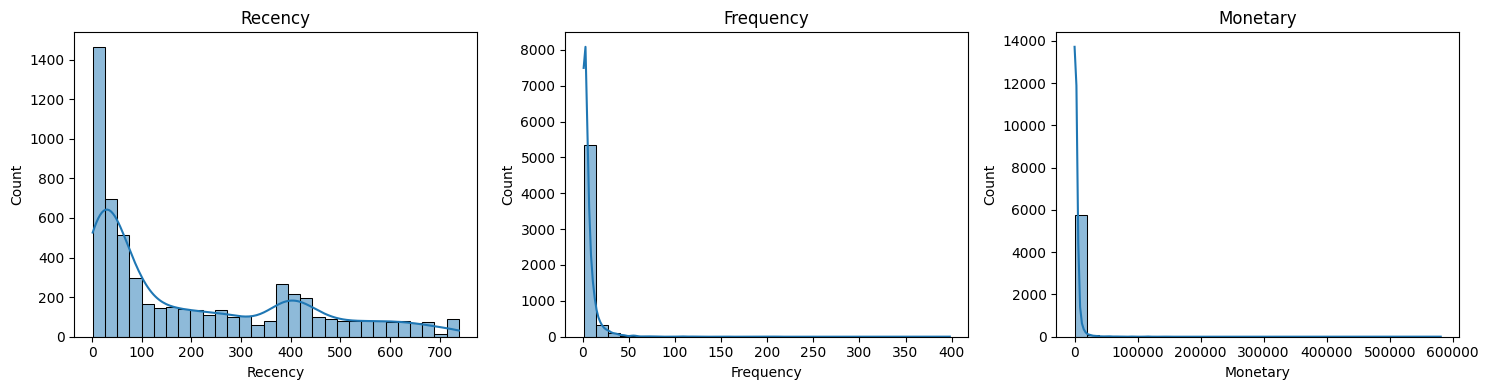

In [8]:
# ----- Quick visualization of RFM distributions -----

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
sns.histplot(rfm['Recency'], bins=30, kde=True)
plt.title('Recency')

plt.subplot(1, 3, 2)
sns.histplot(rfm['Frequency'], bins=30, kde=True)
plt.title('Frequency')

plt.subplot(1, 3, 3)
sns.histplot(rfm['Monetary'], bins=30, kde=True)
plt.title('Monetary')

plt.tight_layout()
plt.show()


In [9]:
# ----- Scale RFM features for clustering -----

rfm_features = rfm[['Recency', 'Frequency', 'Monetary']].copy()

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features)

print("Scaled shape:", rfm_scaled.shape)


Scaled shape: (5878, 3)


In [10]:
# ----- KMeans clustering on RFM -----

k = 4  # number of clusters

kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
kmeans.fit(rfm_scaled)

# Cluster labels for each customer
rfm['Cluster'] = kmeans.labels_

rfm.head()


,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12346,326,12,77556.46,1
12347,2,8,4921.53,1
12348,75,5,2019.40,1
12349,19,4,4428.69,1
12350,310,1,334.40,0


In [11]:
# ----- Analyze clusters -----

cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': ['mean', 'median'],
    'Frequency': ['mean', 'median'],
    'Monetary': ['mean', 'median', 'count']
})

cluster_summary


Recency          Frequency              Monetary                 
               mean median        mean median           mean     median count
Cluster                                                                      
0        462.517224  430.0    2.213679    1.0     749.231879     373.01  2003
1         66.758342   41.0    7.313608    5.0    2948.946362    1332.18  3836
2         25.942857    4.0  103.714286   84.0   81340.992343   57215.33    35
3          3.500000    1.5  212.500000  153.5  428611.997500  421020.07     4

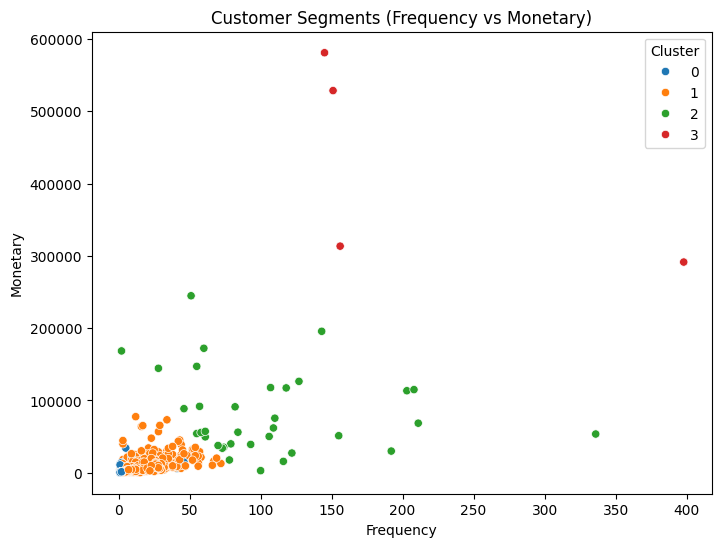

In [12]:
# ----- Simple scatter plot: Frequency vs Monetary colored by Cluster -----

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=rfm['Frequency'],
    y=rfm['Monetary'],
    hue=rfm['Cluster'],
    palette='tab10'
)
plt.title('Customer Segments (Frequency vs Monetary)')
plt.show()


In [14]:
# ----- Save RFM clusters to CSV -----

output_path = "E:/retail-ml-pipeline-project/data_processed/customer_rfm_clusters.csv"
rfm.reset_index().to_csv(output_path, index=False)

print("RFM clusters saved to:", output_path)


RFM clusters saved to: E:/retail-ml-pipeline-project/data_processed/customer_rfm_clusters.csv


In [18]:
# ----- Daily sales trend analysis -----
# Create a date-only column
df["InvoiceDateDate"] = df["InvoiceDate"].dt.date

# Group by date and sum TotalPrice
daily_sales = df.groupby("InvoiceDateDate")["TotalPrice"].sum().sort_index()

daily_sales.head(), daily_sales.tail()




(InvoiceDateDate
 2009-12-01    43894.87
 2009-12-02    52762.06
 2009-12-03    67413.62
 2009-12-04    33913.81
 2009-12-05     9803.05
 Name: TotalPrice, dtype: float64,
 InvoiceDateDate
 2011-12-05     58081.09
 2011-12-06     45989.66
 2011-12-07     69230.60
 2011-12-08     50395.96
 2011-12-09    184347.66
 Name: TotalPrice, dtype: float64)

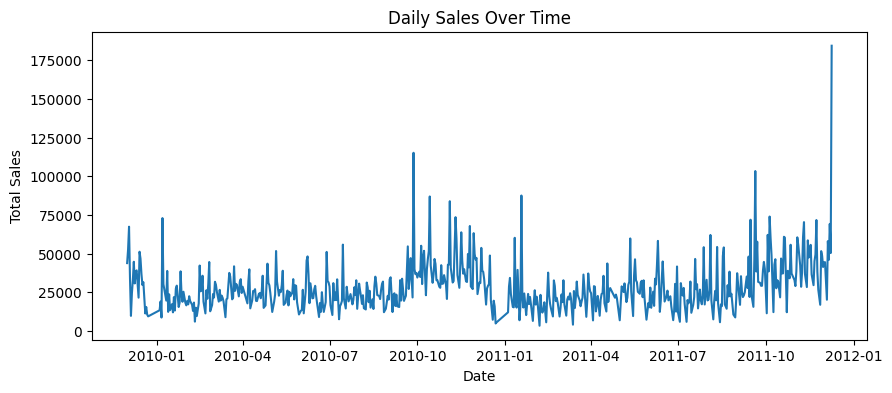

In [19]:
# Plot daily sales trend

plt.figure(figsize=(10, 4))
daily_sales.plot()
plt.title("Daily Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.show()


In [2]:
import sys
print(sys.executable)


e:\retail-ml-pipeline-project\venv\Scripts\python.exe


In [3]:
import sys
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install statsmodels


  Using cached pip-25.3-py3-none-any.whl.metadata (4.7 kB)
Using cached pip-25.3-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 25.0.1
    Uninstalling pip-25.0.1:
      Successfully uninstalled pip-25.0.1
  Using cached statsmodels-0.14.6-cp312-cp312-win_amd64.whl.metadata (9.8 kB)
  Using cached patsy-1.0.2-py2.py3-none-any.whl.metadata (3.6 kB)
Using cached statsmodels-0.14.6-cp312-cp312-win_amd64.whl (9.5 MB)
Using cached patsy-1.0.2-py2.py3-none-any.whl (233 kB)

   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [

In [1]:
from statsmodels.tsa.arima.model import ARIMA

# Convert to pandas Series with DateTimeIndex
ts = daily_sales.copy()
ts.index = pd.to_datetime(ts.index)

# Split into train and test sets
train_size = int(len(ts) * 0.9)  # 90% train, 10% test

train = ts.iloc[:train_size]
test = ts.iloc[train_size:]

print("Train size:", train.shape, "Test size:", test.shape)

model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()

print(model_fit.summary())


ModuleNotFoundError: No module named 'statsmodels'